In [1]:
import torchvision
import torch

from matplotlib.pyplot import *
%matplotlib widget

import numpy as np

import torchvision.datasets as datasets

In [2]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

# Allocate images and labels to numpy arrays

In [3]:
targets = np.zeros(len(mnist_trainset))
imgs = np.zeros((len(mnist_trainset), 28,28))

for _i in range(len(mnist_trainset)):
    targets[_i] = mnist_trainset[_i][1]
    imgs[_i] = mnist_trainset[_i][0]

In [4]:
test_targets = np.zeros(len(mnist_testset))
test_imgs = np.zeros((len(mnist_testset), 28,28))

for _i in range(len(mnist_testset)):
    test_targets[_i] = mnist_testset[_i][1]
    test_imgs[_i] = mnist_testset[_i][0]

# Make a mask for each region

[252. 252. 280.]


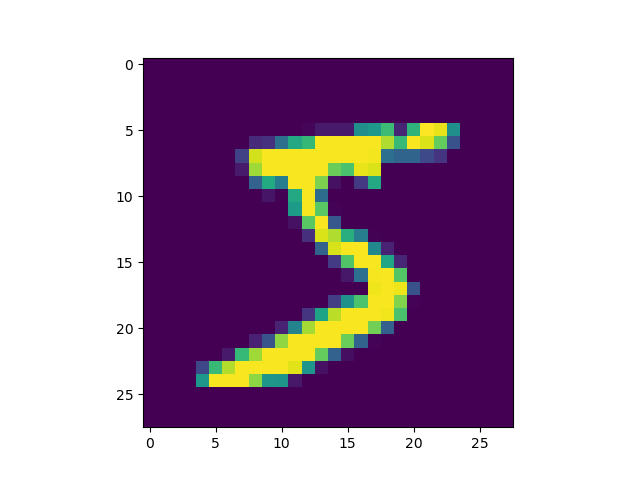

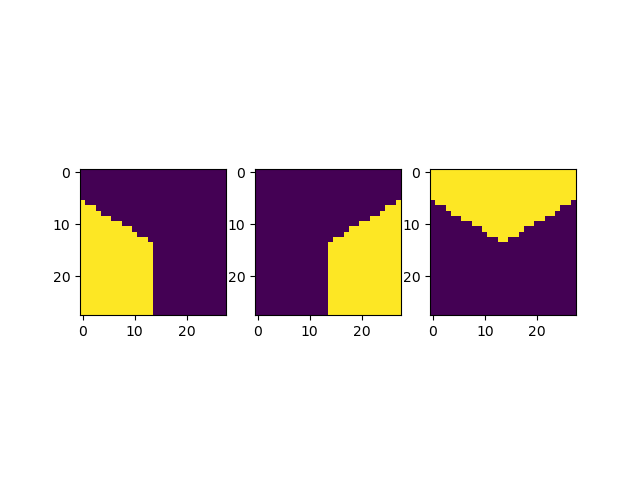

In [5]:
fig, axs = subplots(1)
axs.imshow(imgs[0])

img = imgs[0]

def Dist(shape=(28,28)):
    dists = np.zeros((*shape, 3))

    x = np.arange(-int(shape[0]/2), int(shape[0]/2)+1)
    y = np.arange(-int(shape[1]/2), int(shape[1]/2)+1)

    x = (x[1:]+x[:-1])/2
    y = (y[1:]+y[:-1])/2
    
    xx, yy = np.meshgrid(x, y)

    angles = np.arctan2(yy, xx)
    
    
    for _i in range(shape[0]):
        for _j in range(shape[1]):
            if np.pi/2<=angles[_i, _j]<=np.pi or -np.pi<=angles[_i,_j]<=-5*np.pi/6:
                dists[_i,_j,0] += 1
            elif -np.pi/6<=angles[_i, _j]<np.pi/2:
                dists[_i,_j,1] += 1
            elif -5*np.pi/6<angles[_i, _j]<-np.pi/6:
                dists[_i,_j,2] += 1
            
    fig, axs = subplots(1, 3)
    axs[0].imshow(dists[:, :, 0])
    axs[1].imshow(dists[:, :, 1])
    axs[2].imshow(dists[:, :, 2])
    
    return dists
    
dists = Dist((28, 28))

print(np.sum(dists, axis=(0,1)))

In [7]:
target_color = np.array([153., 153., 255.])/255.

# Make RGB Filter

In [13]:
def GetFilter(imgs, targets, number, dists, rgb):
    numbers = imgs[np.where(targets==number)[0]]
    
    numbers_mean = np.mean(numbers, axis=0)/255.
    
    numbers_mean_casted = np.zeros((4*28, 3*28, 3))
    
    for _rgb in range(3):
        numbers_mean_casted[28+14:14+ 2*28, 28:2*28, _rgb] += numbers_mean * dists[:, :, _rgb] * rgb[_rgb]
    
    filter = np.fft.fft2(numbers_mean_casted, axes=(0,1), norm="forward")
    filter = np.fft.fftshift(filter, axes=(1,2))
    
    return filter, numbers_mean_casted

interest_number = 0

filter, numbers_mean = GetFilter(imgs, targets, interest_number, dists, target_color)

[]

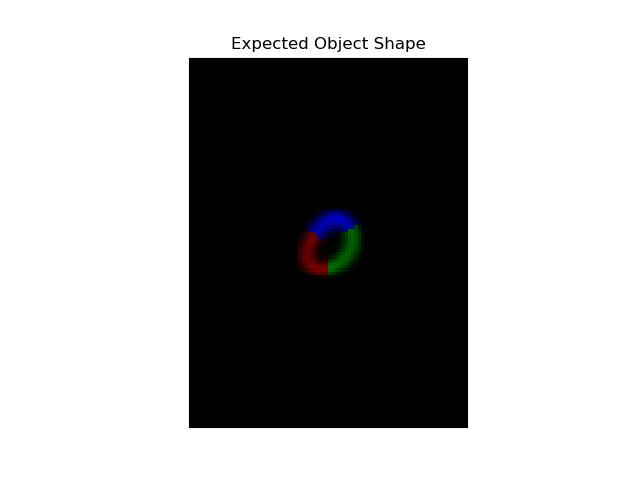

In [14]:
fig, axs = subplots(1)
axs.imshow(numbers_mean)

axs.set_title("Expected Object Shape")
axs.set_xticks([])
axs.set_yticks([])

# Make Input Imgs

In [15]:
def PaintImg(img, rgb, rgb_indices, dists):
    canvas = np.zeros((*img.shape, 3))
    
    for _rgb in range(3):
        canvas[:, :, _rgb] = img * dists[:,:,rgb_indices[_rgb]] * rgb[_rgb]
        
    return canvas

def InputImg(plots):
    canvas = np.zeros((4*28, 3*28, 3))
    label = np.zeros((4, 3))
    
    ind = [(0,0), (0,1), (0,2),
           (1,0), (1,1), (1,2),
           (2,0), (2,1), (2,2),
           (3,0), (3,1), (3,2)]
    
    target = np.random.choice(np.arange(12))
    label[ind[target][0], ind[target][1]] = 1.
    
    canvas[ind[target][0]*28:(ind[target][0]+1)*28, ind[target][1]*28:(ind[target][1]+1)*28] = plots[0]
    
    ind.remove(ind[target])
    
    ind_i = np.arange(11)
    np.random.shuffle(ind_i)
    
    for _i in range(len(ind)):
        canvas[ind[ind_i[_i]][0]*28:(ind[ind_i[_i]][0]+1)*28 , (ind[ind_i[_i]][1])*28:(ind[ind_i[_i]][1]+1)*28] = plots[_i+1]
    
    return canvas, label

In [18]:
test_numbers = test_imgs[np.where(test_targets==interest_number)[0]]/255.

colors = np.array([target_color, target_color, target_color,
                   target_color, target_color, target_color,
                   target_color, target_color, target_color,
                   confusion_colors[0], confusion_colors[1], confusion_colors[2]])

input_imgs = np.zeros((test_numbers.shape[0], 4*28, 3*28, 3))
labels = np.zeros((test_numbers.shape[0], 4, 3))
for _i in range(len(test_numbers)):
    img = test_numbers[_i]
    
    plot = np.zeros((12, 28, 28, 3))
    
    indices = [(0,1,2), (2,0,1), (1,2,0),  ## rotation
               (0,0,0), (1,1,1), (2,2,2),  ## all colors in same place
               (0,2,1), (2,1,0), (1,0,2),  ## permutations
               (0,1,2), (0,1,2), (0,1,2)]  ## color confusion
    
    for _l in range(len(indices)):
        plot[_l] = PaintImg(img, colors[_l], indices[_l], dists)
        
    input_imgs[_i], labels[_i] = InputImg(plot)

    

Text(0.5, 1.0, 'Label')

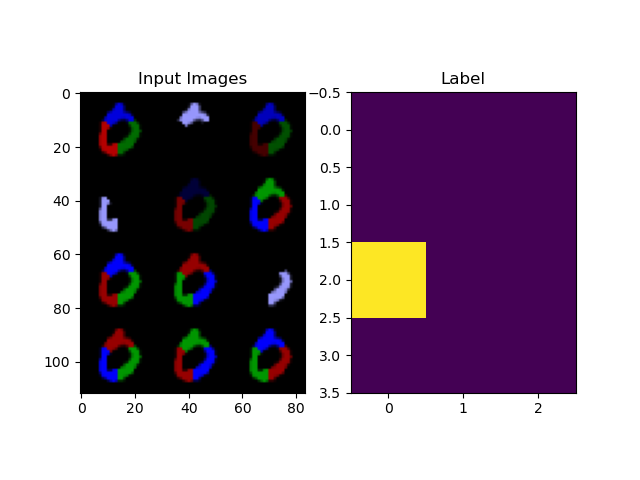

In [23]:
fig, axs = subplots(1, 2)
axs[0].imshow(input_imgs[0])

axs[0].set_title("Input Images")

axs[1].imshow(labels[0])

axs[1].set_title("Label")

# Run Multiple Classifications

In [16]:
M = 10

accuracy = np.zeros(M)
for _m in range(M):
    confusion_colors = np.random.rand(3,3)
    
    test_numbers = test_imgs[np.where(test_targets==interest_number)[0]]/255.

    colors = np.array([target_color, target_color, target_color,
                    target_color, target_color, target_color,
                    target_color, target_color, target_color,
                    confusion_colors[0], confusion_colors[1], confusion_colors[2]])

    input_imgs = np.zeros((test_numbers.shape[0], 4*28, 3*28, 3))
    labels = np.zeros((test_numbers.shape[0], 4, 3))
    for _i in range(len(test_numbers)):
        img = test_numbers[_i]
        
        plot = np.zeros((12, 28, 28, 3))
        
        indices = [(0,1,2), (2,0,1), (1,2,0),  ## rotation
                (0,0,0), (1,1,1), (2,2,2),  ## all colors in same place
                (0,2,1), (2,1,0), (1,0,2),  ## permutations
                (0,1,2), (0,1,2), (0,1,2)]  ## color confusion
        
        for _l in range(len(indices)):
            plot[_l] = PaintImg(img, colors[_l], indices[_l], dists)
            
        input_imgs[_i], labels[_i] = InputImg(plot)
        
    input_imgs_fft = np.fft.fft2(input_imgs, axes=(1,2))
    input_imgs_fft = np.fft.fftshift(input_imgs_fft, axes=(1,2))
        
    output_fft = np.zeros(input_imgs_fft.shape, dtype=np.complex64)
    for _i in range(len(input_imgs_fft)):
        output_fft[_i] = filter * input_imgs_fft[_i]
        
    output = np.fft.ifft2(output_fft, axes=(1,2))
    output = np.fft.ifftshift(output, axes=(1,2))
        
    _y = np.abs(output)**2

    #_y = (_y - _y.min())/(_y.max() - _y.min())

    for _rgb in range(3):
        _y[:,:,:,_rgb] = target_color[_rgb] * _y[:,:,:,_rgb]
            
    y = np.sum(_y, axis=3)

    y_val = np.zeros((y.shape[0], 4, 3))
    for _i in range(4):
        for _j in range(3):
            y_val[:, _i, _j] = np.sum(y[:, _i*28:(_i+1)*28, _j*28:(_j+1)*28], axis=(1,2))
            
    y_pred = np.zeros(y_val.shape)
    for _i in range(y_val.shape[0]):
        y_pred[_i, np.where(y_val[_i]==np.max(y_val[_i]))[0][0], np.where(y_val[_i]==np.max(y_val[_i]))[1][0]] = 1.
            
    accuracy[_m] = 100.*len(np.where(y_pred == labels)[0])/(12*len(y_pred))

In [21]:
print(f"Mean Accuracy = {accuracy.mean()}; Standard Deviation = {accuracy.std()}")

Mean Accuracy = 84.62074829931973; Standard Deviation = 0.8376968225410942
